# Submission 1: Data Preparation and Analysis

In [1]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import statsmodels.tsa.stattools as ts
import datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera
import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR, AutoReg
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

In [3]:
TRAIN_TEST_RATIO = 0.2

In [4]:
covid_pharma_tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'NVAX']
start = '2020-03-01'
end = datetime.datetime.now().date().strftime('%Y-%m-%d')
print(f"Period: {start} to {end}")

Period: 2020-03-01 to 2020-08-16


In [5]:
prices = pdr.get_data_yahoo(covid_pharma_tickers, start=start, end=end)['Adj Close']
prices.tail()

Symbols,PFE,MRNA,JNJ,AZN,NVAX
Date,,,,,
2020-08-10,38.389999,72.010002,148.029999,54.940784,178.509995
2020-08-11,37.790001,68.970001,146.970001,54.742371,149.479996
2020-08-12,38.330002,69.519997,149.660004,56.290001,124.419998
2020-08-13,38.169998,67.830002,148.000000,55.799999,133.279999
2020-08-14,38.060001,69.150002,148.240005,55.189999,146.509995


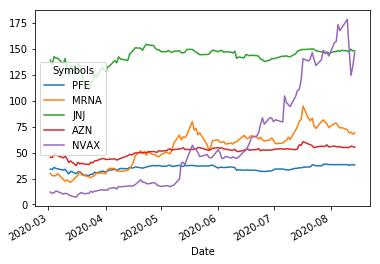

In [6]:
prices.plot()

#### NVAX looks intersting, let's analyse futher.

NVAX


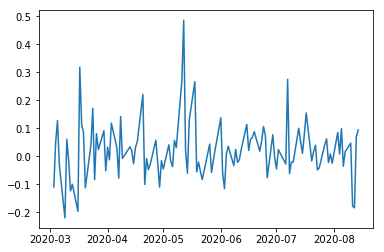

In [7]:
data = prices['NVAX']
print(data.name)
ret = np.log(data).diff().dropna()
plt.plot(ret)

### Calculate mean and standard deviation

In [8]:
mean_return = ret.mean()
std_return = ret.std()
basic_stats = pd.DataFrame([mean_return, std_return], columns = [data.name], index = ['Mean return', 'Volatility'])
basic_stats

,NVAX
Mean return,0.021556
Volatility,0.101325


### Implement Technical indicators
Let's use MA model first

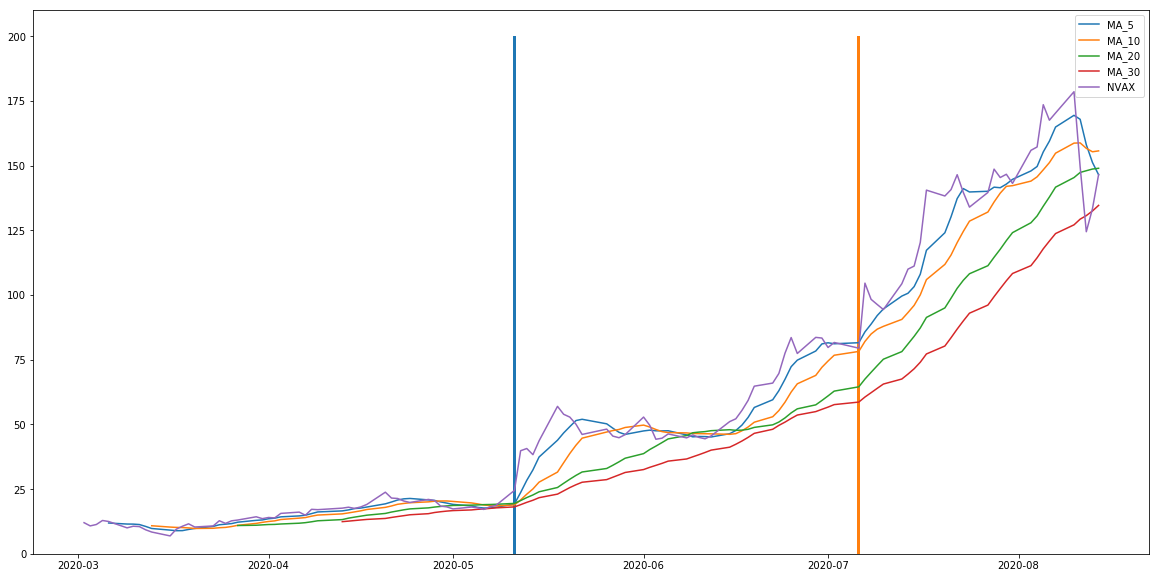

In [9]:
mas = []
plt.figure(figsize=(20,10))
for i in [5, 10, 20, 30]:
    ma = data.rolling(i).mean()
    mas.append(ma)
    plt.plot(ma, label=f'MA_{i}')
plt.plot(data, label='NVAX')
plt.bar(x=pd.to_datetime('20200511', format='%Y%m%d', errors='ignore'), height=200, width=0.5)
plt.bar(x=pd.to_datetime('20200706', format='%Y%m%d', errors='ignore'), height=200, width=0.5)
plt.legend()
plt.show()

#### Preparing test and train data

In [10]:
train, test = train_test_split(data, test_size=TRAIN_TEST_RATIO, shuffle=False)
start_train = train.index[0].to_pydatetime()
end_train = train.index[-1].to_pydatetime()
start_test = test.index[0].to_pydatetime()
end_test = test.index[-1].to_pydatetime()
print(f"Fitting model from {start_train} to {end_train}")
print(f"Predicting from {start_test} to {end_test}")

Fitting model from 2020-03-02 00:00:00 to 2020-07-13 00:00:00
Predicting from 2020-07-14 00:00:00 to 2020-08-14 00:00:00


### Identify structural breaks - TODO

In [25]:
#The Chow test
import statsmodels.api as sm
import re

price_range=[]
date_range = []
date_list = []
for prices in data:
    price_range.append(prices)

for dates in data.index:
    date_list.append(dates)
    date_range.append((dates-data.index[0]).days)

In [12]:
res = sm.OLS(price_range, date_range).fit()
res.ssr


55469.6761596368

In [14]:
break1_ith = date_list.index(pd.to_datetime('20200511'))
break2_ith = date_list.index(pd.to_datetime('20200706'))

total_date_range_break1to2  = date_range[:break2_ith]; total_price_range_break1to2 = price_range[:break2_ith];
total_date_range_break2to3  = date_range[break1_ith:]; total_price_range_break2to3 = price_range[break1_ith:];
res_break1to2 = sm.OLS(total_price_range_break1to2 , total_date_range_break1to2).fit()
res_break2to3= sm.OLS(total_price_range_break2to3, total_date_range_break2to3).fit()

date_range_break1 = date_range[:break1_ith]; price_range_break1= price_range[:break1_ith];
date_range_break2 = date_range[break1_ith:break2_ith]; price_range_break2= price_range[break1_ith:break2_ith];
date_range_break3 = date_range[break2_ith:]; price_range_break3= price_range[break2_ith:];
res_break1= sm.OLS(price_range_break1, date_range_break1).fit()
res_break2= sm.OLS(price_range_break2, date_range_break2).fit()
res_break3= sm.OLS(price_range_break3, date_range_break3).fit()

print('SSR_Break 1:', res_break1.ssr)
print('SSR_Break 2:', res_break2.ssr)
print('SSR_Break 3:', res_break3.ssr)

SSR_Break 1: 1375.6446180066341
SSR_Break 2: 3134.207520728508
SSR_Break 3: 9078.131759879529


In [31]:
#Computing the F test Statistics for each break
#Break 1 to 2

test_statistics1to2 = ((res_break1to2.ssr-(res_break1.ssr+res_break2.ssr))/2)/((res_break1.ssr+res_break2.ssr)/(break2_ith+1))

print("Test Statistics for Break 1 ", test_statistics1to2, "as compare to the critical value at 99.9% at 7.5")

Test Statistics for Break 1  24.06511093124817 as compare to the critical value at 99.9% at 7.5


In [29]:
#Computing the F test Statistics for each break
#Break 2 to 3

test_statistics2to3 = ((res_break2to3.ssr-(res_break2.ssr+res_break3.ssr))/2)/((res_break2.ssr+res_break3.ssr)/(len(data)-break2_ith))

print("Test Statistics for Break 2 ", test_statistics2to3, "as compare to the critical value at 99.9% at 8.7")

Test Statistics for Break 2  35.84530199917788 as compare to the critical value at 99.9% at 8.7


### Apply Bera-Jarque test for returns

In [ ]:
jb, pvalue, skew, kurtosis = jarque_bera(ret)
jb_test= pd.DataFrame([jb, pvalue, skew, kurtosis], index=['Jarque-Bera test statistic', 'p-value', 'Skewness', 'Kurtosis'])
jb_test

In [ ]:
if pvalue < 0.05:
    print("Return is likely not normal")
else:
    print("Return is likely normal")

### Apply a cointegration test - TODO

In [ ]:
#TODO

### Forcast next period using AR(1) model

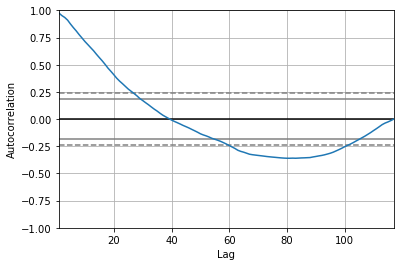

In [32]:
autocorrelation_plot(data)

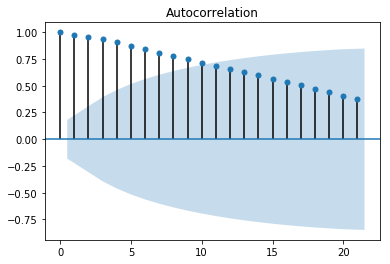

In [33]:
_ = plot_acf(data)

In [34]:
def predict(m_fit, start, end, **kwargs):
    # make predictions
    predictions = m_fit.predict(start=start, end=end, **kwargs)
    for i in range(len(predictions)):
        print(f'predicted={predictions.values[i]}, expected={test.values[i]}')
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE: {rmse}')
    # plot result
    plt.plot(test.values)
    plt.plot(predictions.values, color='red')
    plt.show()

#### Although AR model from statsmodels suggest the best lag parameter to be 12, let's try with AR(1) model first

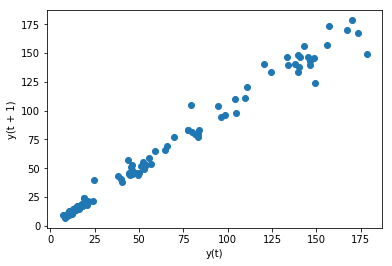

In [35]:
lag_plot(data)

#### We can observe a strong correlation between prices of 2 consecutive days


predicted=106.63796872773673, expected=109.97000122070312
predicted=109.0003888808668, expected=111.1500015258789
predicted=111.4081125823791, expected=120.29000091552734
predicted=113.86200860724298, expected=140.49000549316406
predicted=116.36296239071095, expected=138.22999572753906
predicted=118.91187634780891, expected=140.69000244140625
predicted=121.50967019895307, expected=146.4499969482422
predicted=124.15728130181112, expected=139.58999633789062
predicted=126.85566498952747, expected=133.92999267578125
predicted=129.60579491543447, expected=139.60000610351562
predicted=132.4086634043743, expected=148.60000610351562
predicted=135.2652818107577, expected=145.36000061035156
predicted=138.17668088348944, expected=146.6199951171875
predicted=141.14391113789173, expected=143.10000610351562
predicted=144.1680432347599, expected=155.8699951171875
predicted=147.25016836668715, expected=157.1699981689453
predicted=150.39139865179786, expected=173.49000549316406
predicted=153.5928675350

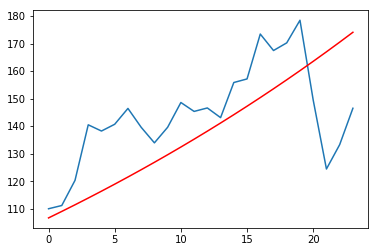

In [36]:
ar_1 = AutoReg(train, lags=1).fit()
predict(ar_1, len(train), len(train)+len(test)-1)

### Forcast next period using suggested optimal lag parameter

In [37]:
def fit_model(train, model_wrapper, test_ratio=0.1):
    # train autoregression
    m = model_wrapper(train)
    m_fit = m.fit()
    # plot residual
    residuals = pd.DataFrame(m_fit.resid)
    residuals.plot()
    residuals.plot(kind='kde')
    return m_fit

Lag: 12
Coefficients: const       0.186204
L1.NVAX     0.896163
L2.NVAX    -0.025571
L3.NVAX     0.054558
L4.NVAX     0.286976
L5.NVAX     0.005830
L6.NVAX    -0.461210
L7.NVAX     0.393706
L8.NVAX    -0.349614
L9.NVAX     0.203302
L10.NVAX   -0.086777
L11.NVAX   -0.056485
L12.NVAX    0.185690
dtype: float64


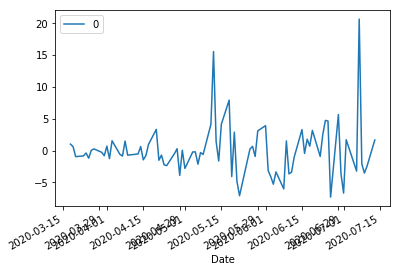

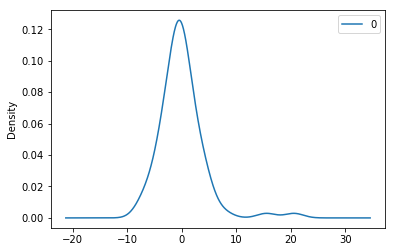

In [38]:
# usage
ar_wrapper = lambda train_data: AR(train_data)
ar_fit = fit_model(train, ar_wrapper, TRAIN_TEST_RATIO)
print(f"Lag: {ar_fit.k_ar}")
print(f"Coefficients: {ar_fit.params}")

predicted=113.80475474247496, expected=109.97000122070312
predicted=105.99082667622474, expected=111.1500015258789
predicted=114.1477882174704, expected=120.29000091552734
predicted=114.23981412343159, expected=140.49000549316406
predicted=123.27377881306947, expected=138.22999572753906
predicted=121.99902494396767, expected=140.69000244140625
predicted=121.46024015812787, expected=146.4499969482422
predicted=130.23004735891126, expected=139.58999633789062
predicted=131.6158379791084, expected=133.92999267578125
predicted=138.99396020724254, expected=139.60000610351562
predicted=135.57034598242703, expected=148.60000610351562
predicted=142.66536540715532, expected=145.36000061035156
predicted=148.06424732628815, expected=146.6199951171875
predicted=150.7654778089572, expected=143.10000610351562
predicted=155.96410051336386, expected=155.8699951171875
predicted=156.44910414243853, expected=157.1699981689453
predicted=166.0674299616891, expected=173.49000549316406
predicted=167.879659360

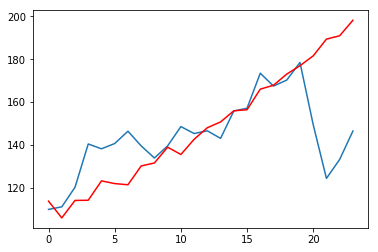

In [39]:
predict(ar_fit, len(train), len(train)+len(test)-1)

In [43]:
len(train)+len(test)-1

116